Goes very roughly through this environment setup, and how we can obtain embeddings at the same time as the words, and through all this do GAIL :-)

# Starting off with the chatbot tutorial, so we can load in the dataset. 

https://pytorch.org/tutorials/beginner/chatbot_tutorial.html?highlight=chatbot%20tutorial

In [61]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math

import matplotlib.pyplot as plt
%matplotlib inline
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [2]:
print(device)

cpu


In [5]:
corpus_name = "cornell movie-dialogs corpus"
corpus = os.path.join("../dat/", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "movie_lines.txt"))

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


In [6]:
# Splits each line of the file into a dictionary of fields
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines


# Groups fields of lines from `loadLines` into conversations based on *movie_conversations.txt*
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            utterance_id_pattern = re.compile('L[0-9]+')
            lineIds = utterance_id_pattern.findall(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

In [7]:
# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict, conversations list, and field ids
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

# Load lines and process conversations
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus...

Loading conversations...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't dat

In [17]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [18]:
MAX_LENGTH = 10  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs # in 


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)


Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008

pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


In [19]:
pairs

[['there .', 'where ?'],
 ['you have my word . as a gentleman', 'you re sweet .'],
 ['hi .', 'looks like things worked out tonight huh ?'],
 ['you know chastity ?', 'i believe we share an art instructor'],
 ['have fun tonight ?', 'tons'],
 ['well no . . .', 'then that s all you had to say .'],
 ['then that s all you had to say .', 'but'],
 ['but', 'you always been this selfish ?'],
 ['do you listen to this crap ?', 'what crap ?'],
 ['what good stuff ?', 'the real you .'],
 ['the real you .', 'like my fear of wearing pastels ?'],
 ['wow', 'let s go .'],
 ['she okay ?', 'i hope so .'],
 ['they do to !', 'they do not !'],
 ['did you change your hair ?', 'no .'],
 ['no .', 'you might wanna think about it'],
 ['who ?', 'joey .'],
 ['great', 'would you mind getting me a drink cameron ?'],
 ['it s more', 'expensive ?'],
 ['hey sweet cheeks .', 'hi joey .'],
 ['where ve you been ?', 'nowhere . . . hi daddy .'],
 ['you are so completely unbalanced .', 'can we go now ?'],
 ['what ?', 'in th . fo

# Quick Test: Flair Embeddings

In [22]:
pairs[100][0]

'why re you doing this ?'

In [23]:
from flair.embeddings import WordEmbeddings
from flair.data import Sentence

# init embedding
glove_embedding = WordEmbeddings('glove')

In [24]:
# create sentence.
sentence = Sentence(pairs[100][0])

# embed a sentence using glove.
glove_embedding.embed(sentence)

# now check out the embedded tokens.
for token in sentence:
    print(token)
    print(token.embedding)

Token: 1 why
tensor([ 1.8450e-01,  5.1461e-01,  6.5342e-01, -4.2173e-01, -8.1430e-01,
         5.0029e-02, -4.1870e-01, -4.1949e-02,  4.7558e-01, -5.4651e-01,
         4.3974e-01,  2.6532e-01,  2.1381e-01, -7.1729e-02, -1.7475e-01,
        -1.8682e-01, -1.2933e-01,  4.7129e-01, -6.2407e-01,  5.4606e-01,
        -4.2295e-02, -1.1002e-01, -3.1637e-01, -6.2179e-01, -2.4532e-02,
         2.5281e-01, -1.8242e-02, -8.5596e-01,  9.6847e-02,  3.9929e-02,
        -2.7546e-02,  6.8141e-01,  1.8839e-01,  1.2421e-02, -1.8829e-01,
         3.3089e-01, -2.0723e-02,  2.8868e-01,  5.7478e-01, -3.4546e-01,
        -6.1522e-01, -1.1323e-01,  9.6484e-02, -4.9250e-01, -6.4248e-01,
        -2.6363e-02,  3.2317e-01, -3.1298e-01, -4.2312e-01, -9.6755e-01,
         4.7128e-01,  1.7033e-01,  1.7940e-01,  6.7091e-01, -1.6210e-01,
        -1.9417e+00,  2.3473e-01,  1.3247e-01,  1.2179e+00,  6.0500e-01,
        -2.5138e-01,  1.0135e+00, -1.2321e-01, -2.3109e-01,  1.1575e+00,
         3.2664e-01,  6.7967e-01,  6.2

In [53]:
x = torch.stack([token.embedding for token in sentence])

In [55]:
x

tensor([[ 1.8450e-01,  5.1461e-01,  6.5342e-01, -4.2173e-01, -8.1430e-01,
          5.0029e-02, -4.1870e-01, -4.1949e-02,  4.7558e-01, -5.4651e-01,
          4.3974e-01,  2.6532e-01,  2.1381e-01, -7.1729e-02, -1.7475e-01,
         -1.8682e-01, -1.2933e-01,  4.7129e-01, -6.2407e-01,  5.4606e-01,
         -4.2295e-02, -1.1002e-01, -3.1637e-01, -6.2179e-01, -2.4532e-02,
          2.5281e-01, -1.8242e-02, -8.5596e-01,  9.6847e-02,  3.9929e-02,
         -2.7546e-02,  6.8141e-01,  1.8839e-01,  1.2421e-02, -1.8829e-01,
          3.3089e-01, -2.0723e-02,  2.8868e-01,  5.7478e-01, -3.4546e-01,
         -6.1522e-01, -1.1323e-01,  9.6484e-02, -4.9250e-01, -6.4248e-01,
         -2.6363e-02,  3.2317e-01, -3.1298e-01, -4.2312e-01, -9.6755e-01,
          4.7128e-01,  1.7033e-01,  1.7940e-01,  6.7091e-01, -1.6210e-01,
         -1.9417e+00,  2.3473e-01,  1.3247e-01,  1.2179e+00,  6.0500e-01,
         -2.5138e-01,  1.0135e+00, -1.2321e-01, -2.3109e-01,  1.1575e+00,
          3.2664e-01,  6.7967e-01,  6.

Let's pretend that's sufficent. Next, our object is to construct an OpenAI Gym - like environment to house this data, where every Q&A pair corresponds to a trajectory we seek to imitate!

In [56]:
class DialogEnvironment(object):
    """
    
    Gym environment for dialog.
    
    """
    def __init__(self, mode='train'):
        

        voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir) # in theory can trim here, but this is fine
        
        self.pairs = pairs
        if mode == 'train': # TODO
            self.pair = self.pairs[:-10]
        elif mode == 'test':
            self.conversations = self.pairss[-10:]
            
        else:
            print("Uh Oh!")

        self.conversations_visited = []
        
    def clear(self):
        """
        Essentially restart counting process. 
        """
        self.conversations_visited = [] #
    def current_state(self):
        return i,j # i for current conversation index, j for current word (these should be odd? )
    
    def reset(self):
        # pick a random i in length of conversation pairs. If already visited, skip. 
        
        self.i = random.randint(a=0,b=len(self.pairs))
        self.conversations_visited.append(self.i)
        self.conversation = self.pairs[self.i]
        
        self.j = 0 #initial state is the first point. 
        state = self.conversation[0]
        expert_action = self.conversation[1]
        
        # create sentence.
        state_sentence = Sentence(state)
        expert_sentence = Sentence(expert_action)
        

        # embed a sentence using glove.
        glove_embedding.embed(state_sentence)
        glove_embedding.embed(expert_sentence)
        state_embedding = torch.stack([token.embedding for token in state_sentence])
        expert_embedding = torch.stack([token.embedding for token in expert_sentence])
        
        
        
        return state, expert_action, state_embedding, expert_embedding
    
    
    def step(self,action):
        """
        Null for now. 
        """
        done = True
        return done


In [57]:
env = DialogEnvironment()

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008


In [58]:
state, expert_action, state_embedding, expert_embedding = env.reset()

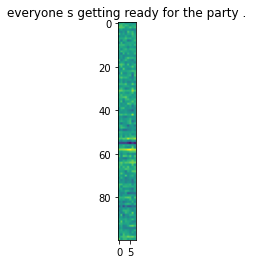

In [66]:
plt.title(state)
plt.imshow(state_embedding.T)

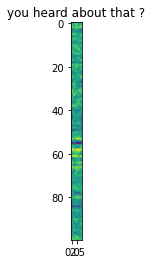

In [67]:
plt.title(expert_action)
plt.imshow(expert_embedding.T)

### Cool! This is a little slow, but works. Let's look at a few trajectories.

In [72]:
n_episodes = 10
for episode in range(n_episodes):
    state, expert_action, state_embedding, expert_embedding = env.reset()
    done = False
    while not done:
        done = env.step(expert_action)
        print(state, '_|_',expert_action)
        print(state_embedding.shape, '_|_',expert_embedding.shape)


van cartier . _|_ you know ? about me ? about everything ?
torch.Size([3, 100]) _|_ torch.Size([9, 100])
sheriff behan doc holliday . _|_ forgive me if i don t shake hands .
torch.Size([5, 100]) _|_ torch.Size([9, 100])
well . . .what do you say ? _|_ i m late .
torch.Size([9, 100]) _|_ torch.Size([4, 100])
annie i think we should have a toast . _|_ a toast ?
torch.Size([9, 100]) _|_ torch.Size([3, 100])
what s so funny ? _|_ nothing . . .
torch.Size([5, 100]) _|_ torch.Size([4, 100])
you lost your head . _|_ i was just showing emotion .
torch.Size([5, 100]) _|_ torch.Size([6, 100])
well i don t know . _|_ why don t you get it .
torch.Size([6, 100]) _|_ torch.Size([7, 100])
i think three . . . _|_ three weeks .
torch.Size([6, 100]) _|_ torch.Size([3, 100])
peter kelson ? _|_ yes . . . and you are ?
torch.Size([3, 100]) _|_ torch.Size([8, 100])
thieves . _|_ why ?
torch.Size([2, 100]) _|_ torch.Size([2, 100])
